In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
class Arm:
    def __init__(self, p):
        self.p = p
    
    def pull(self):
        return np.random.binomial(1, self.p)

class MultiBandit:
    def __init__(self, probs = [0.1, 0.2, 0.7, 0.5]):
        self.__arms = [Arm(p) for p in probs]
        self.__regret = 0
        self.__maxp = max(probs)

    def num_arms(self):
        return len(self.__arms)

    def pull(self, arm_num):
        reward = self.__arms[arm_num].pull()
        self.__regret += self.__maxp-self.__arms[arm_num].p
        return reward
    
    def regret(self):
        return self.__regret

#### Defining the ε-greedy algorithm class

In [14]:
class EpsilonGreedyAlgorithm:
    def __init__(self, num_arms, horizon, epsilon):
        # Initialize our algorithm
        self.num_arms = num_arms                    # Number of arms present in the bandit
        self.horizon = horizon                      # Total Horizon of the algorithm
        self.epsilon = epsilon                      # epsiolon value for the algorithm
        self.timestep = 0                           # The current timestep while running the algorithm
        self.arm_pulls = np.zeros(num_arms)         # History of number of times each arm was pulled
        self.arm_rewards = np.zeros(num_arms)       # History of the total reward accumulated by each arm
        self.regrets = np.zeros(horizon)            # Total regret at each timestep of the horizon

        # adding an average reward array to keep track of average rewards generated by each arm
        self.avg_rewards = np.zeros(num_arms)

    def give_best_arm(self):
        #returning the argument of the arm with max average reward
        return np.argmax(self.avg_rewards)

    def select_arm(self):
        # Select arm at each time step. You are supposed to return the index of which 
        # arm has been selected to pull at this timestep

        #ensuring each arm gets explored at least once before doing the epsilon thingy
        for i in range(self.num_arms):
            if self.arm_pulls[i] == 0:
                return i
            
        if np.random.uniform(0, 1) < self.epsilon :
            return np.random.choice(range(0, self.num_arms))
        else :
            return self.give_best_arm()

    def run_algorithm(self, bandit):
        # This is the proper algorithm. Already completed
        for _ in range(self.horizon):
            arm_to_pull = self.select_arm()             # Select the arm using the algorithm
            reward = bandit.pull(arm_to_pull)           # Pull the arm and find our the reward
            self.arm_pulls[arm_to_pull] += 1            # Update the arm pull count and arm reward count
            self.arm_rewards[arm_to_pull] += reward

            # updating the arm reward array (I know I wasnt supposed to change this particular function but it isnt a major change sooo it should be fine right?)
            self.avg_rewards[arm_to_pull] = self.arm_rewards[arm_to_pull]/self.arm_pulls[arm_to_pull]

            self.timestep += 1                          # Update the timestep
            self.regrets[_] = bandit.regret()           # Store the regret values at each timestep
    
    def plot(self):
        plt.plot(self.regrets)
        plt.xlabel('Timestep')
        plt.ylabel('Cumulative Regret')
        plt.title('Regret over Time')
        plt.show()

Visualizing how accurate the ε-greedy algorithm is (regret plot is at the last code block)
- running the algorithm 40 times with 200 iterations each to see how many times it guesses the correct arm
- I know it probably isnt the _most_ optimal way to judge and compare the different algorithms but I've commited to this idea so cant go back

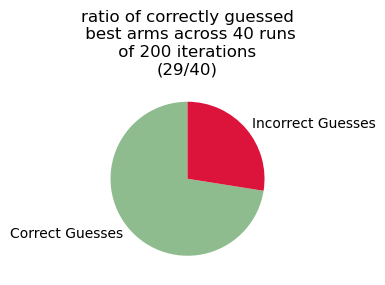

In [15]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5] #can keep changing this array to see accuracy on each one
H = 200
runs = 40
best_arm = np.argmax(probs)
correct_guesses = 0

# Running 40 times
for _ in range(runs):
    bandit = MultiBandit(probs)
    algorithm = EpsilonGreedyAlgorithm(num_arms=bandit.num_arms(), horizon=H, epsilon=0.2)
    algorithm.run_algorithm(bandit)

    if algorithm.give_best_arm() == best_arm:
        correct_guesses += 1

labels = ['Correct Guesses', 'Incorrect Guesses']
sizes = [correct_guesses, runs - correct_guesses]
colors = ['darkseagreen', 'crimson']

plt.figure(figsize=(2.5, 2.5))
plt.pie(sizes, labels=labels, colors=colors, startangle=90)
plt.title(f'ratio of correctly guessed\n best arms across {runs} runs\n of {H} iterations \n({correct_guesses}/{runs})')
plt.show()

#### Defining the upper confidence bound algorithm class

In [16]:
class UCBAlgorithm:
    def __init__(self, num_arms, horizon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.timestep = 0
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def give_best_arm(self):
        avg_rewards = np.zeros(self.num_arms)
        for i in range(self.num_arms):
            if self.arm_pulls[i] > 0:
                avg_rewards[i] = self.arm_rewards[i] / self.arm_pulls[i]
            else:
                avg_rewards[i] = 0
        return np.argmax(avg_rewards)

    def select_arm(self):
        for i in range(self.num_arms):
            if self.arm_pulls[i] == 0:
                return i
        avg_rewards = self.arm_rewards / self.arm_pulls
        confidence_bounds = np.sqrt(0.5 * np.log(self.timestep + 1) / self.arm_pulls)
        return np.argmax(avg_rewards + confidence_bounds)

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)
            self.arm_pulls[arm_to_pull] += 1
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1
            self.regrets[t] = bandit.regret()

    def plot(self):
        plt.plot(self.regrets, label="UCB")


Visualizing how accurate the upper confidence bound algorithm is
- again running the algorithm 40 times with 200 iterations each to see how many times it guesses the correct arm

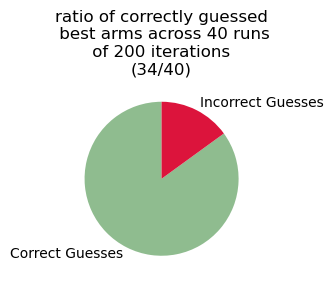

In [37]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5] #can keep changing this array to see accuracy on each one
H = 200
runs = 40
best_arm = np.argmax(probs)
correct_guesses = 0

# Running 40 times
for _ in range(runs):
    bandit = MultiBandit(probs)
    algorithm = UCBAlgorithm(num_arms=bandit.num_arms(), horizon=H)
    algorithm.run_algorithm(bandit)

    if algorithm.give_best_arm() == best_arm:
        correct_guesses += 1

labels = ['Correct Guesses', 'Incorrect Guesses']
sizes = [correct_guesses, runs - correct_guesses]
colors = ['darkseagreen', 'crimson']

plt.figure(figsize=(2.5, 2.5))
plt.pie(sizes, labels=labels, colors=colors, startangle=90)
plt.title(f'ratio of correctly guessed\n best arms across {runs} runs\n of {H} iterations \n({correct_guesses}/{runs})')
plt.show()

#### Defining thompson sampling algorithm class

In [38]:
class ThompsonSamplingAlgorithm:
    def __init__(self, num_arms, horizon):
        self.num_arms = num_arms
        self.horizon = horizon
        self.timestep = 0
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    def give_best_arm(self):
        total_trials = self.successes + self.failures
        with np.errstate(divide='ignore', invalid='ignore'):
            est_probs = np.where(total_trials > 0, self.successes / total_trials, 0)
        return np.argmax(est_probs)

    def select_arm(self):
        samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1)
                   for i in range(self.num_arms)]
        return np.argmax(samples)

    def run_algorithm(self, bandit):
        for t in range(self.horizon):
            arm_to_pull = self.select_arm()
            reward = bandit.pull(arm_to_pull)
            if reward == 1:
                self.successes[arm_to_pull] += 1
            else:
                self.failures[arm_to_pull] += 1
            self.timestep += 1
            self.regrets[t] = bandit.regret()

    def plot(self):
        plt.plot(self.regrets, label="Thompson Sampling")

Visualizing how accurate the thompson sampling algorithm is
- aand again running the algorithm 40 times with 200 iterations each to see how many times it guesses the correct arm

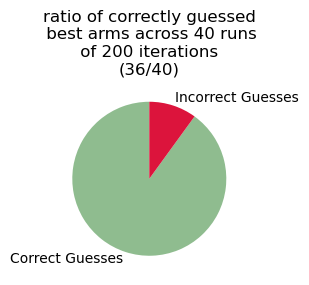

In [19]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5] #can keep changing this array to see accuracy on each one
H = 200
runs = 40
best_arm = np.argmax(probs)
correct_guesses = 0

# Running 40 times
for _ in range(runs):
    bandit = MultiBandit(probs)
    algorithm = ThompsonSamplingAlgorithm(num_arms=bandit.num_arms(), horizon=H)
    algorithm.run_algorithm(bandit)

    if algorithm.give_best_arm() == best_arm:
        correct_guesses += 1

labels = ['Correct Guesses', 'Incorrect Guesses']
sizes = [correct_guesses, runs - correct_guesses]
colors = ['darkseagreen', 'crimson']

plt.figure(figsize=(2.5, 2.5))
plt.pie(sizes, labels=labels, colors=colors, startangle=90)
plt.title(f'ratio of correctly guessed\n best arms across {runs} runs\n of {H} iterations \n({correct_guesses}/{runs})')
plt.show()

### Side by side regret comparison
#### edit the array in the first line as per your choice

[Epsilon-Greedy] Total Regret: 15.6 | Assumed Best Arm: 2
[UCB]           Total Regret: 10.600000000000003 | Assumed Best Arm: 2
[Thompson]      Total Regret: 8.700000000000003 | Assumed Best Arm: 2


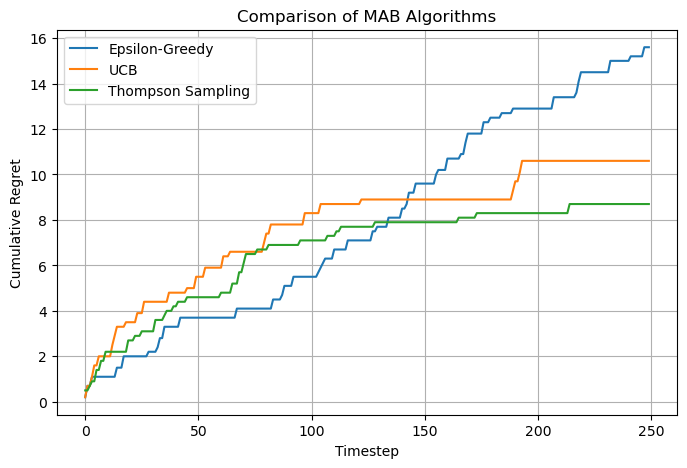

In [39]:
probs = [0.4, 0.1, 0.6, 0.2]   # Make custom Multi-armed Bandit. Should work while grading code
H = 250

# Creating bandits (multiple bandits because each will have a different regret value) and Algorithm instances
bandit_eg = MultiBandit(probs)
bandit_ucb = MultiBandit(probs)
bandit_ts = MultiBandit(probs)

epsilon_greedy = EpsilonGreedyAlgorithm(num_arms=bandit_eg.num_arms(), horizon=H, epsilon=0.2)
ucb = UCBAlgorithm(num_arms=bandit_ucb.num_arms(), horizon=H)
thompson = ThompsonSamplingAlgorithm(num_arms=bandit_ts.num_arms(), horizon=H)

# Run the algorithm
epsilon_greedy.run_algorithm(bandit_eg)
ucb.run_algorithm(bandit_ucb)
thompson.run_algorithm(bandit_ts)

# Display total regret
print(f"[Epsilon-Greedy] Total Regret: {bandit_eg.regret()} | Assumed Best Arm: {epsilon_greedy.give_best_arm()}")
print(f"[UCB]           Total Regret: {bandit_ucb.regret()} | Assumed Best Arm: {ucb.give_best_arm()}")
print(f"[Thompson]      Total Regret: {bandit_ts.regret()} | Assumed Best Arm: {thompson.give_best_arm()}")

plt.figure(figsize=(8, 5))
plt.plot(epsilon_greedy.regrets, label='Epsilon-Greedy')
plt.plot(ucb.regrets, label='UCB')
plt.plot(thompson.regrets, label='Thompson Sampling')
plt.xlabel('Timestep')
plt.ylabel('Cumulative Regret')
plt.title('Comparison of MAB Algorithms')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion (Based on different regret plots for different values)

**Probably the Best: `Thompson Sampling`**  
- The regret curve seems to really decrease its slope very quickly although UCB wins sometimes.

**Okayish: `UCB`**  
- Not consistent in slopes, reflective of how the algorithm really works - like it goes back and forth between options much more than thompson. 

**Ehh: `ε-greedy`**  
- Might start out the best sometimes but sticking to a single strategy always makes it very stubborn and the slope stays high and that I guess logically checks out - statistically the slope should be a steady value

*I mean to be fair I've seen every single permutation of the three winning on the graph and I'd like to delve more into the maths to really judge the algorithms but these are the conclusions that I made from looking at a bunch of regret plots*
